This notebook provides a summary of the predictive analyses using task or survey data to predict a set of factors based on demographic/health measures.  

#### Provenance:
- data generated for each run using behav_prediction.py via Singularity container
- multiple runs generated on lonestar5 using singularity_analyses/mk_singularity_script_factor.py
- individual data files combined on ls5 using singularity_analyses/ls5/check_completion.py which generates singularity_analyses/ls5/lasso_data.pkl (which is copied to mac for next step)
- data structures further collapsed using export_data_for_R_factor.py



In [1]:
import os,glob,sys
import pickle
import numpy,pandas
pandas.options.display.max_colwidth = 0
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import display, HTML
import seaborn as sns
import scipy.stats
from statsmodels.sandbox.stats.multicomp import multipletests
# %load_ext rpy2.ipython
from scipy.cluster.hierarchy import dendrogram,ward,cut_tree,leaves_list
from scipy.spatial.distance import pdist
from sklearn.preprocessing import StandardScaler

import selfregulation.prediction.behavpredict as behavpredict
from prediction_notebook_utils import get_pval, get_importances,get_importance_list,plotvars

clf='lasso'
acc,features=pickle.load(open('singularity_analyses/ls5/%s_data_collapsed.pkl'%clf,'rb'))
cont_measure='r2' # use r^2 or MAE for non-binary variables

Check all variables to make sure they have the correct number of observations (120), and create tables summarizing data.

In [2]:

allvars={}
datasets=[]
for k in acc.keys():
    if len(acc[k])==0:
        print('no data for',k)
        continue
    datasets.append(k)
    for v in acc[k][cont_measure]['scores_cv']:
        if v=='tmp':
            continue
        allvars[v]=cont_measure
        
alldata={'r2':pandas.DataFrame(),'MAE':pandas.DataFrame(),
        'r2_pval':pandas.DataFrame()}
target_n={}
goodcount={}
for d in datasets:
    if len(acc[k])==0:
        print('no data for',k)
        continue
    
    goodcount[d]={}
    target_n[d]=120
    examplefeature=list(features[d].keys())[0]
    print(d,features[d][examplefeature].shape[1])

    for v in acc[d]['r2']['scores_cv']:
        if not v in acc[d][allvars[v]]['scores_cv']:
            goodcount[d][v]=0
        else:
            goodcount[d][v]=numpy.isfinite(acc[d][allvars[v]]['scores_cv'][v]).sum()
        if goodcount[d][v]<target_n[d]:
            print(d,v,goodcount[d][v],features[d][v].shape[1])

for v in allvars:
    vars={}
    for k in datasets:
        if not 'r2' in acc[k]:
            continue
        vars[k]=acc[k]['r2']['scores_cv'].mean().T
    df=pandas.DataFrame(vars,index=[v])
    alldata['r2']=alldata['r2'].append(df)

    vars={}
    for k in datasets:
        if not 'MAE' in acc[k]:
            continue
        vars[k]=acc[k]['MAE']['scores_cv'].mean().T
    df=pandas.DataFrame(vars,index=[v])
    alldata['MAE']=alldata['MAE'].append(df)
   


no data for baseline
no data for baseline_shuffle
no data for motor_selective_stop_signal
no data for baseline_shuffle_shuffle
no data for motor_selective_stop_signal_shuffle
task 105
survey 65
discounting 6
intelligence 3
stopping 12
impulsivity 11
big5 5
risktaking 19
grit 1
emotion_regulation 2
bisbas 4
thresh 13
drift 25
nondecision 13
stroop 4
dot_pattern_expectancy 7
attention_network_task 6
threebytwo 4
stop_signal 6
kirby 3
discount_titrate 1
tower_of_london 4
columbia_card_task_hot 5
task_shuffle 105
survey_shuffle 65
discounting_shuffle 6
intelligence_shuffle 3
stopping_shuffle 12
impulsivity_shuffle 11
big5_shuffle 5
risktaking_shuffle 19
grit_shuffle 1
emotion_regulation_shuffle 2
bisbas_shuffle 4
thresh_shuffle 13
drift_shuffle 25
nondecision_shuffle 13
stroop_shuffle 4
dot_pattern_expectancy_shuffle 7
attention_network_task_shuffle 6
threebytwo_shuffle 4
stop_signal_shuffle 6
kirby_shuffle 3
discount_titrate_shuffle 1
tower_of_london_shuffle 4
columbia_card_task_hot_shuff

In [3]:
features['survey'].keys()

dict_keys(['MentalIllness', 'ProblemDrinking', 'Obesity', 'Smoking', 'SmokingSeverity', 'Financial'])

Compute p values

In [4]:
#NOTE: factors were exported from R in the wrong order
# This dict renames them
# This should be fixed in the final run


def get_pval(target,null,allvars,datasets,acc,verbose=False):
    data=[]
    vars=[i for i in list(allvars.keys()) if not i=='tmp']
    vars.sort()
    for v in vars:
        if verbose:
            print(target,null,v)
        if not v in acc[target][allvars[v]]['scores_cv'] or not v in acc[null][allvars[v]]['scores_cv']:
            data.append([allvars[v],numpy.nan,numpy.nan,numpy.nan,numpy.nan,numpy.nan])
            continue
        targdist=acc[target][allvars[v]]['scores_cv'][v].dropna()
        targmean=targdist.mean()
        nulldist=acc[null][allvars[v]]['scores_cv'][v].dropna()
        nullmean=nulldist.mean()
        targstd=targdist.std()
        pval=1-scipy.stats.percentileofscore(nulldist,targmean)/100.
        if targstd>0:
            #es=(targmean-nullmean)/targstd
            es=targmean-nullmean
        else:
            es=numpy.nan
        insample=acc[target][allvars[v]]['scores_insample_unbiased'][v].mean()
        data.append([allvars[v],targmean,nullmean,es,insample,pval])
    #newvars=[factor_renaming_dict[i] for i in vars]
    df=pandas.DataFrame(data,index=vars,columns=['Measure','Target mean','Null Mean','Effect size','In-sample','p_unc'])
    return(df)



pvals={}
for d in datasets:
    if d.find('shuffle')>-1 or len(acc[d])==0:
        continue
    print(d)
    pvals[(d,d+'_shuffle')]=get_pval(d,d+'_shuffle',allvars,datasets,acc)

pvals_fdr={}
for k in pvals:
    tmp=multipletests(pvals[k]['p_unc'])
    pvals[k]['p_fdr']=tmp[1]

task
survey
discounting
intelligence
stopping
impulsivity
big5
risktaking
grit
emotion_regulation
bisbas
thresh
drift
nondecision
stroop
dot_pattern_expectancy
attention_network_task
threebytwo
stop_signal
kirby
discount_titrate
tower_of_london
columbia_card_task_hot


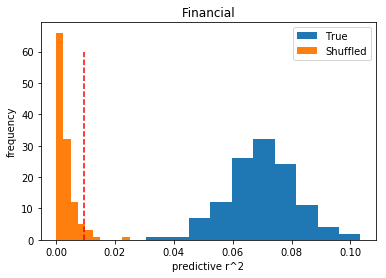

In [39]:
v='Financial'
shufacc=acc['survey_shuffle']['r2']['scores_cv'][v]
goodacc=acc['survey']['r2']['scores_cv'][v]
plt.hist(goodacc)
plt.hist(shufacc)
plt.legend(['True','Shuffled'])
plt.xlabel('predictive r^2')
plt.ylabel('frequency')
plt.title(v)
cutoff=scipy.stats.scoreatpercentile(shufacc,95)
plt.plot([cutoff,cutoff],[0,60],'r--')
plt.savefig('nulldist.png',dpi=300)

## Example of overfitting

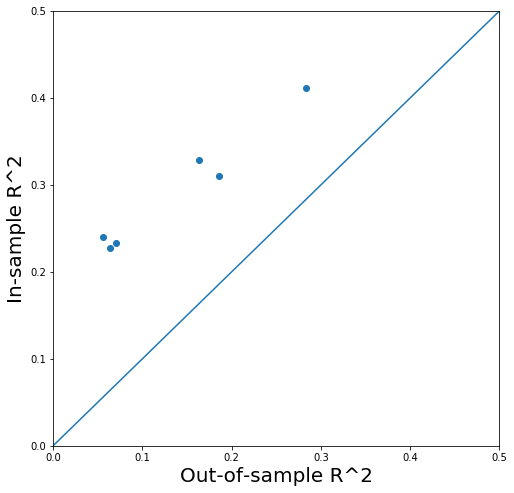

In [16]:
k=('survey','survey_shuffle')
plt.figure(figsize=(8,8))
r2data=pvals[k].query('Measure == "r2"')
plt.scatter(r2data['Target mean'],r2data['In-sample'])
plt.plot([0,1],[0,1])
plt.axis([0,0.5,0,0.5])
plt.xlabel('Out-of-sample R^2',fontsize=20)
plt.ylabel('In-sample R^2',fontsize=20)
plt.savefig('overfitting_factors.png',dpi=300)

## Show variables with greater prediction for survey vs. baseline

In [6]:
pthresh=0.05
sigp={}
plot_sep_vars=False
k=('survey','survey_shuffle')
sigp[k]=pvals[k].query('p_fdr <= %f'% pthresh).sort_values(by='Effect size',ascending=False)
imp=get_importance_list(sigp[k],k[0],features)
sigp[k]=sigp[k].join(imp)
display(sigp[k])
if plot_sep_vars:
    for v in sigp[k].index:
        plotvars(v,pvals,datasets,allvars)

,Measure,Target mean,Null Mean,Effect size,In-sample,p_unc,p_fdr,top features
MentalIllness,r2,0.283091,0.002470,0.280621,0.411015,0.0,0.0,"[[five_facet_mindfulness_survey.nonjudge, time_perspective_survey.past_negative, future_time_perspective_survey.future_time_perspective]]"
ProblemDrinking,r2,0.185752,0.002540,0.183212,0.310503,0.0,0.0,"[[sensation_seeking_survey.disinhibition, bis11_survey.Motor, dospert_rt_survey.health_safety]]"
Obesity,r2,0.163577,0.002728,0.160849,0.328177,0.0,0.0,"[[eating_survey.emotional_eating, brief_self_control_survey.self_control, leisure_time_activity_survey.activity_level]]"
Financial,r2,0.070071,0.003195,0.066876,0.232971,0.0,0.0,"[[time_perspective_survey.past_negative, time_perspective_survey.past_positive, leisure_time_activity_survey.activity_level]]"
Smoking,r2,0.063404,0.002926,0.060479,0.227213,0.0,0.0,"[[dospert_rt_survey.health_safety, sensation_seeking_survey.disinhibition, sensation_seeking_survey.experience_seeking]]"
SmokingSeverity,r2,0.056038,0.002839,0.053198,0.239657,0.0,0.0,"[[five_facet_mindfulness_survey.act_with_awareness, dospert_rt_survey.health_safety, ten_item_personality_survey.openness]]"


In [17]:
k=('survey','survey_shuffle')
for i in sigp[k].index:
    print(i)
    display(get_importances(i,k[0],features,10))
    print('')

MentalIllness


,importance,mean
five_facet_mindfulness_survey.nonjudge,1.000000,-0.069963
time_perspective_survey.past_negative,1.000000,0.229883
future_time_perspective_survey.future_time_perspective,1.000000,-0.090998
ten_item_personality_survey.emotional_stability,1.000000,-0.159003
selection_optimization_compensation_survey.optimization.ReflogTr,0.975000,0.035597
dospert_eb_survey.financial,0.933333,0.026045
time_perspective_survey.past_positive,0.900000,-0.026712
dospert_eb_survey.social,0.891667,0.040371
upps_impulsivity_survey.negative_urgency,0.691667,0.023227
upps_impulsivity_survey.lack_of_premeditation,0.675000,-0.025188



ProblemDrinking


,importance,mean
sensation_seeking_survey.disinhibition,1.000000,0.142250
bis11_survey.Motor,1.000000,0.091999
dospert_rt_survey.health_safety,1.000000,0.182999
brief_self_control_survey.self_control,0.891667,-0.038863
eating_survey.cognitive_restraint,0.825000,0.029465
bis_bas_survey.BIS,0.758333,0.022181
sensation_seeking_survey.experience_seeking,0.758333,0.022465
selection_optimization_compensation_survey.elective_selection,0.616667,-0.013653
dospert_rt_survey.recreational,0.591667,0.014628
dospert_eb_survey.social,0.458333,0.008789



Obesity


,importance,mean
eating_survey.emotional_eating,1.000000,0.195758
brief_self_control_survey.self_control,1.000000,-0.171100
leisure_time_activity_survey.activity_level,1.000000,-0.137528
eating_survey.uncontrolled_eating,0.950000,0.066183
dospert_eb_survey.recreational,0.925000,-0.037259
bis_bas_survey.BIS,0.916667,-0.080383
dospert_rp_survey.recreational,0.866667,0.037054
ten_item_personality_survey.openness,0.833333,-0.033802
dospert_rt_survey.financial,0.825000,-0.032217
erq_survey.suppression,0.808333,-0.031003



Financial


,importance,mean
time_perspective_survey.past_negative,1.000000,-0.107688
time_perspective_survey.past_positive,1.000000,0.097866
leisure_time_activity_survey.activity_level,1.000000,0.066034
eating_survey.cognitive_restraint,0.991667,0.060649
five_facet_mindfulness_survey.observe,0.958333,-0.064014
dospert_rt_survey.financial,0.866667,0.047069
selection_optimization_compensation_survey.compensation,0.758333,0.029963
bis_bas_survey.BAS_drive,0.700000,0.020899
dospert_rt_survey.health_safety,0.666667,-0.021526
dospert_rt_survey.social,0.641667,-0.017987



Smoking


,importance,mean
dospert_rt_survey.health_safety,1.000000,0.157865
sensation_seeking_survey.disinhibition,0.983333,0.064922
sensation_seeking_survey.experience_seeking,0.641667,0.016266
ten_item_personality_survey.extraversion,0.641667,0.013641
dospert_rt_survey.social,0.583333,0.013008
five_facet_mindfulness_survey.describe,0.475000,0.011240
dospert_eb_survey.ethical,0.358333,-0.011015
eating_survey.cognitive_restraint,0.316667,-0.007440
dospert_rt_survey.recreational,0.316667,0.005424
selection_optimization_compensation_survey.loss_based_selection,0.283333,-0.006000



SmokingSeverity


,importance,mean
five_facet_mindfulness_survey.act_with_awareness,1.000000,0.117895
dospert_rt_survey.health_safety,1.000000,0.148121
ten_item_personality_survey.openness,0.966667,0.052027
selection_optimization_compensation_survey.loss_based_selection,0.858333,-0.028254
ten_item_personality_survey.agreeableness,0.850000,0.035389
eating_survey.emotional_eating,0.841667,-0.046599
sensation_seeking_survey.experience_seeking,0.833333,0.031990
dospert_rp_survey.ethical,0.833333,0.046608
bis_bas_survey.BAS_drive,0.758333,0.026055
eating_survey.cognitive_restraint,0.666667,-0.016113


## Show variables with greater prediction for task vs. baseline

In [8]:
k=('task','task_shuffle')
sigp[k]=pvals[k].query('p_fdr <= %f'% pthresh).sort_values(by='Effect size',ascending=False)
imp=get_importance_list(sigp[k],k[0],features)
sigp[k]=sigp[k].join(imp)
display(sigp[k])
if plot_sep_vars:
    for v in sigp[k].index:
        plotvars(v,pvals,datasets,allvars)

,Measure,Target mean,Null Mean,Effect size,In-sample,p_unc,p_fdr,top features
Financial,r2,0.100781,0.002340,0.098441,0.317861,0.000000,0.000000,"[[writing_task.positive_probability, bickel_titrator.hyp_discount_rate_medium.logTr, cognitive_reflection_survey.correct_proportion]]"
SmokingSeverity,r2,0.019619,0.002696,0.016923,0.277500,0.008333,0.040978,"[[kirby.hyp_discount_rate_large.logTr, stim_selective_stop_signal.hddm_drift, simon.hddm_thresh]]"
MentalIllness,r2,0.009737,0.002159,0.007577,0.214306,0.008333,0.040978,"[[writing_task.positive_probability, kirby.hyp_discount_rate_medium.logTr, threebytwo.hddm_thresh]]"


In [18]:
k=('task','task_shuffle')
for i in sigp[k].index:
    print(i)
    display(get_importances(i,k[0],features,10))
    print('')

Financial


,importance,mean
writing_task.positive_probability,1.000000,0.129395
bickel_titrator.hyp_discount_rate_medium.logTr,1.000000,-0.066487
cognitive_reflection_survey.correct_proportion,1.000000,0.107374
simon.hddm_non_decision,0.991667,-0.054485
writing_task.neutral_probability,0.991667,0.075945
digit_span.forward_span,0.891667,0.027446
psychological_refractory_period_two_choices.PRP_slope,0.783333,-0.027245
dietary_decision.health_sensitivity,0.716667,0.016740
kirby.hyp_discount_rate_large.logTr,0.691667,-0.016844
directed_forgetting.hddm_drift,0.675000,-0.020552



SmokingSeverity


,importance,mean
kirby.hyp_discount_rate_large.logTr,0.900000,0.071293
stim_selective_stop_signal.hddm_drift,0.816667,0.036926
simon.hddm_thresh,0.808333,0.035068
angling_risk_task_always_sunny.release_loss_percent,0.800000,0.039481
tower_of_london.num_extra_moves,0.733333,-0.025278
columbia_card_task_hot.gain_sensitivity,0.658333,-0.024577
information_sampling_task.Fixed_Win_motivation,0.500000,-0.012130
columbia_card_task_hot.avg_cards_chosen,0.433333,0.008538
attention_network_task.conflict_hddm_drift,0.425000,0.007594
adaptive_n_back.hddm_thresh,0.341667,0.007787



MentalIllness


,importance,mean
writing_task.positive_probability,0.966667,-0.065151
kirby.hyp_discount_rate_medium.logTr,0.633333,0.023204
threebytwo.hddm_thresh,0.475000,0.014695
attention_network_task.alerting_hddm_drift,0.358333,-0.009668
local_global_letter.hddm_drift,0.275000,-0.004408
dot_pattern_expectancy.BX-BY_hddm_drift,0.216667,0.003415
local_global_letter.switch_cost_hddm_drift,0.158333,0.002343
tower_of_london.num_optimal_solutions,0.141667,-0.002104
shape_matching.hddm_drift,0.133333,-0.001664
directed_forgetting.hddm_non_decision,0.116667,0.002062


In [10]:
pvals[k]

,Measure,Target mean,Null Mean,Effect size,In-sample,p_unc,p_fdr
Financial,r2,0.100781,0.002340,0.098441,0.317861,0.000000,0.000000
MentalIllness,r2,0.009737,0.002159,0.007577,0.214306,0.008333,0.040978
Obesity,r2,0.010379,0.002992,0.007387,0.237404,0.041667,0.119864
ProblemDrinking,r2,0.001874,0.002440,-0.000567,0.188877,0.541667,0.566597
Smoking,r2,0.002407,0.002112,0.000296,0.210719,0.341667,0.566597
SmokingSeverity,r2,0.019619,0.002696,0.016923,0.277500,0.008333,0.040978


### Make figure for paper

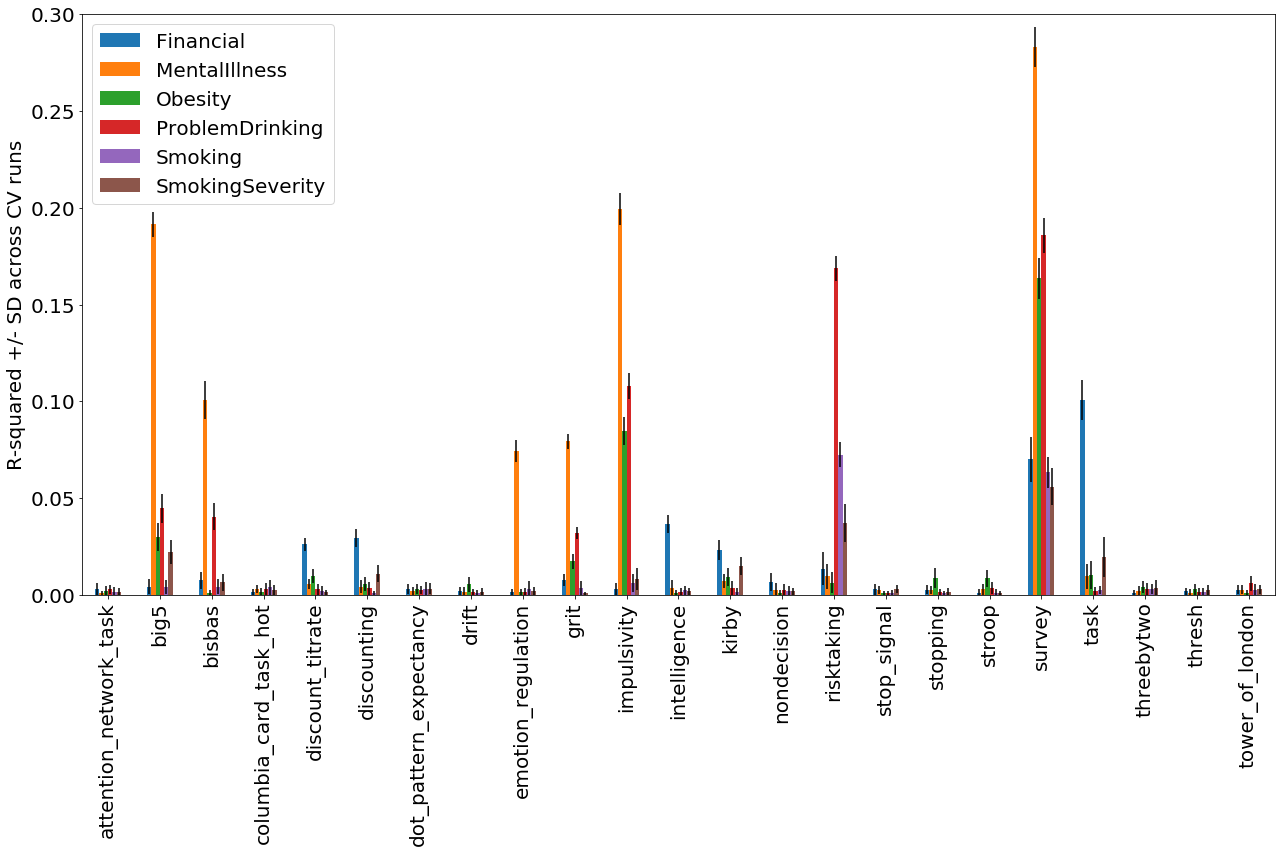

In [11]:

def plot_paper_vars(vars,pvals,datasets,allvars):
    f, axarr = plt.subplots(2, 2,figsize=(18,16))
    xy=[[0,0],[0,1],[1,0],[1,1]]
    ctr=0
    for v in vars:
        df=[]
        errors=[]
        ds=[]
        for k in datasets:
            if not allvars[v] in acc[k]:
                continue
            if not v in acc[k][allvars[v]]['scores_cv']:
                continue
            targdist=acc[k][allvars[v]]['scores_cv'][v].dropna()
            df.append(targdist.mean())
            ds.append(k)
            errors.append(targdist.std())
        df=pandas.DataFrame({'mean':df},index=ds)
        errors=pandas.DataFrame({'mean':errors},index=ds)
        if allvars[v]=='AUROC':
            df.plot.bar(yerr=errors,legend=False,
                    ylim=(0.45,numpy.max(df.values)*1.1),
                        ax=axarr[xy[ctr][0],xy[ctr][1]],
                       title=v)
        else:
            df.plot.bar(yerr=errors,legend=False,
                        ax=axarr[xy[ctr][0],xy[ctr][1]],
                       title=v)
        if xy[ctr][0]==0:
            x_axis = axarr[xy[ctr][0],xy[ctr][1]].axes.get_xaxis()
            x_axis.set_visible(False)
        if xy[ctr][1]==0:
            plt.ylabel(allvars[v]+' +/- SE across CV runs')
        ctr+=1
                                                                  
vars=list(pvals[('survey','survey_shuffle')].index)       
vars.sort()
#def plot_paper_vars2(vars,pvals,datasets,allvars):
if 1:
    f= plt.figure(figsize=(18,12))
    ax=plt.gca()
    data=None
    errors=None
    for v in vars:
        df=[]
        err=[]
        ds=[]
        for k in datasets:
            if k.find('_shuffle')>-1:
                continue
            if not allvars[v] in acc[k]:
                continue
            if not v in acc[k][allvars[v]]['scores_cv']:
                continue
            targdist=acc[k][allvars[v]]['scores_cv'][v].dropna()
            df.append(targdist.mean())
            ds.append(k)
            err.append(targdist.std())
        if data is None:
            data=pandas.DataFrame({v:df},index=ds)
            errors=pandas.DataFrame({v:err},index=ds)
        else:
            data[v]=pandas.DataFrame({v:df},index=ds)
            errors[v]=pandas.DataFrame({v:err},index=ds)
    data.sort_index(inplace=True)    
    if allvars[v]=='AUROC':
        data.plot.bar(yerr=errors,legend=True,
                ylim=(0.45,numpy.max(df.values)*1.1),
                   title=v,ax=ax,fontsize=20)
    else:
        data.plot.bar(yerr=errors,
                   ax=ax,fontsize=20,ylim=[0,0.3])
    plt.ylabel('R-squared +/- SD across CV runs',fontsize=20)
    plt.legend(fontsize=20)   
    plt.tight_layout(1.25)

#plot_paper_vars(figurevars,pvals,datasets,allvars)
plt.savefig('factor_barplots.png',dpi=300)

## Show variables with greater prediction for DDM parameters vs. baseline

### drift

In [40]:
k=('drift','drift_shuffle')
sigp[k]=pvals[k].query('p_unc <= %f'% pthresh).sort_values(by='Effect size',ascending=False)
imp=get_importance_list(sigp[k],k[0],features)
sigp[k]=sigp[k].join(imp)
display(sigp[k])
for v in sigp[k].index:
    plotvars(v,pvals,datasets,allvars)
    print(v)
    print(get_importances(v,k[0],features)  )  
    print('')    


,Measure,Target mean,Null Mean,Effect size,In-sample,p_unc,p_fdr,top features


### Threshold

In [41]:
k=('thresh','thresh_shuffle')
sigp[k]=pvals[k].query('p_unc <= %f'% pthresh).sort_values(by='Effect size',ascending=False)
imp=get_importance_list(sigp[k],k[0],features)
sigp[k]=sigp[k].join(imp)
display(sigp[k])
for v in sigp[k].index:
    plotvars(v,pvals,datasets,allvars)
    print(v)
    print(get_importances(v,k[0],features)  )  
    print('')

,Measure,Target mean,Null Mean,Effect size,In-sample,p_unc,p_fdr,top features


### Nondecision time

In [42]:
k=('nondecision','nondecision_shuffle')
sigp[k]=pvals[k].query('p_unc <= %f'% pthresh).sort_values(by='Effect size',ascending=False)
imp=get_importance_list(sigp[k],k[0],features)
sigp[k]=sigp[k].join(imp)
display(sigp[k])
for v in sigp[k].index:
    plotvars(v,pvals,datasets,allvars)
    print(v)
    print(get_importances(v,k[0],features)  )  
    print('')

,Measure,Target mean,Null Mean,Effect size,In-sample,p_unc,p_fdr,top features


## Show variables with greater prediction for intelligence vs. baseline

In [43]:
k=('intelligence','intelligence_shuffle')
sigp[k]=pvals[k].query('p_fdr <= %f'% pthresh).sort_values(by='Effect size',ascending=False)
imp=get_importance_list(sigp[k],k[0],features)
sigp[k]=sigp[k].join(imp)
display(sigp[k])


,Measure,Target mean,Null Mean,Effect size,In-sample,p_unc,p_fdr,top features
Financial,r2,0.036782,0.002484,0.034298,0.048211,0.0,0.0,"[[cognitive_reflection_survey.correct_proportion, cognitive_reflection_survey.intuitive_proportion, ravens.score]]"


## Show variables with greater prediction for stopping vs. baseline


In [44]:
k=('stopping','stopping_shuffle')
sigp[k]=pvals[k].query('p_fdr <= %f'% pthresh).sort_values(by='Effect size',ascending=False)
imp=get_importance_list(sigp[k],k[0],features)
sigp[k]=sigp[k].join(imp)
display(sigp[k])


,Measure,Target mean,Null Mean,Effect size,In-sample,p_unc,p_fdr,top features


## Show variables with greater prediction for discounting vs. baseline


In [45]:
k=('discounting','discounting_shuffle')
sigp[k]=pvals[k].query('p_fdr <= %f'% pthresh).sort_values(by='Effect size',ascending=False)
imp=get_importance_list(sigp[k],k[0],features)
sigp[k]=sigp[k].join(imp)
display(sigp[k])


,Measure,Target mean,Null Mean,Effect size,In-sample,p_unc,p_fdr,top features
Financial,r2,0.029427,0.002856,0.026571,0.046641,0.0,0.0,"[[bickel_titrator.hyp_discount_rate_medium.logTr, kirby.hyp_discount_rate_large.logTr, discount_titrate.percent_patient]]"


### Assess survey variables in terms of their overall predictive utility


In [ ]:
k=('survey','baseline')
df=pandas.DataFrame()
absfeat=pandas.DataFrame()

for v in features['survey']:
    df[v]=features['survey'][v].mean(0)
    absfeat[v]=(features['survey'][v].abs()>0).mean()
    
mean_imp=df.mean(1)
meanabs_survey=pandas.DataFrame({'meanabs':absfeat.mean(1)}).sort_values(by='meanabs',ascending=False)


In [ ]:
df=pandas.DataFrame()
absfeat=pandas.DataFrame()

for v in features['task']:
    df[v]=features['task'][v].mean(0)
    absfeat[v]=(features['task'][v].abs()>0).mean()
    
mean_imp=df.mean(1)
meanabs_task=pandas.DataFrame({'meanabs':absfeat.mean(1)}).sort_values(by='meanabs',ascending=False)


## Visualize structure of demographic target variables

In [46]:
bp=behavpredict.BehavPredict(verbose=True,
     drop_na_thresh=100,
     skip_vars=['RetirementPercentStocks',
     'HowOftenFailedActivitiesDrinking',
     'HowOftenGuiltRemorseDrinking',
     'AlcoholHowOften6Drinks'],
     add_baseline_vars=True,
     freq_threshold=0.1)
bp.load_demog_data()
bp.get_demogdata_vartypes()


replacing bad WeightPounds value for Index(['s028'], dtype='object')
replacing bad HeightInches value for Index(['s462', 's513', 's517'], dtype='object')
replacing bad CaffienatedSodaCansPerDay value for Index(['s108'], dtype='object')
dropping categorical variable: HispanicLatino
dropping categorical variable: Race
dropping categorical variable: DiseaseDiagnoses
dropping categorical variable: DiseaseDiagnosesOther
dropping categorical variable: MotivationForParticipation
dropping categorical variable: MotivationOther
dropping categorical variable: NeurologicalDiagnoses
dropping categorical variable: NeurologicalDiagnosesDescribe
dropping categorical variable: OtherDebtSources
dropping categorical variable: OtherDrugs
dropping categorical variable: OtherRace
dropping categorical variable: OtherTobaccoProducts
dropping categorical variable: PsychDiagnoses
dropping categorical variable: PsychDiagnosesOther


In [47]:
demogdata=bp.demogdata.copy()
for i in demogdata.columns:
    if not i in features['task'] and not i in features['survey']:
        del demogdata[i]
        print('removing',i)
demogdata=demogdata.T
demogdata['goodvar']=demogdata.isnull().sum(1)<10
demogdata_clean=demogdata.query('goodvar==True')
print(demogdata.shape)
del demogdata_clean['goodvar']
demogdata_clean=demogdata_clean.T

# these are bad vars that don't have features
dropvars=['HowOftenCantStopDrinking',
'HowOftenFailedActivitiesDrinking',
'HowOftenGuiltRemorseDrinking','AlcoholHowOften6Drinks']

for v in dropvars:
    if v in demogdata_clean:
        del demogdata_clean[v]
        print('removing',v)
from sklearn.linear_model import LinearRegression
from fancyimpute import SimpleFill

def residualize_baseline(df):
    # remove baseline vars
    baseline=df[['Age','Sex']]
    data=df.copy()
    del data['Age']
    del data['Sex']
    #x=SimpleFill().complete(baseline)
    lr=LinearRegression()
    for v in data:
        #print('residualizing',v)
        if data[v].isnull().sum()>0:
            y=SimpleFill().complete(data[v].values[:,numpy.newaxis])
        else:
            y=data[v]
        lr.fit(baseline,y)
        data[v]=y - lr.predict(baseline)
    return data
df_resid=residualize_baseline(demogdata_clean)


removing Sex
removing Age
removing HighestEducation
removing HeightInches
removing WeightPounds
removing RelationshipStatus
removing DivorceCount
removing LongestRelationship
removing RelationshipNumber
removing ChildrenNumber
removing HouseholdIncome
removing RetirementAccount
removing RetirementPercentStocks
removing RentOwn
removing MortgageDebt
removing CarDebt
removing EducationDebt
removing CreditCardDebt
removing OtherDebtAmount
removing CoffeeCupsPerDay
removing TeaCupsPerDay
removing CaffienatedSodaCansPerDay
removing CaffieneOtherSourcesDayMG
removing GamblingProblem
removing TrafficTicketsLastYearCount
removing TrafficAccidentsLifeCount
removing ArrestedChargedLifeCount
removing LifetimeSmoke100Cigs
removing HowLongSmoked
removing SmokeEveryDay
removing CigsPerDay
removing HowSoonSmokeAfterWaking
removing AlcoholHowOften
removing AlcoholHowManyDrinksDay
removing AlcoholHowOften6Drinks
removing HowOftenCantStopDrinking
removing HowOftenFailedActivitiesDrinking
removing HowOft

KeyError: "['Age' 'Sex'] not in index"

In [ ]:
dthresh=2.0
dist=1-numpy.abs(df_resid.corr(method='spearman'))
k=ward(numpy.triu(dist))
c=cut_tree(k,height=dthresh)
ll=leaves_list(k)

matches={}
matchnums={}
clustdict={}
for i in numpy.unique(c):
    matches[i]=[]
    matchnums[i]=[]
    for j in numpy.where(c==i)[0]:
        matches[i].append(df_resid.columns[j])
        clustdict[df_resid.columns[j]]=i
        matchnums[i].append(j)

matchdesc={0:'education/height/weight',1:'relationships',2:'domestic',3:'financial/coffee',
          4:'caffeine',5:'legal problems',6:'smoking',7:'alcohol use',
          8:'alcohol/drug problems',9:'mental health',10:'obesity'}

matches

In [ ]:
# get top predictive features for each cluster
impdata={}
binarize_features=True
feature_thresh=1e-5
for i in matchdesc.keys():
    print(matchdesc[i])
    print(matches[i])
    df_subset=df_resid

    df_tmp=pandas.DataFrame()
    absfeat_tmp=pandas.DataFrame()

    for v in matches[i]:
        # drop variables that don't have features for both task and survey
        if not v in features['task'] or not v in features['survey']:
            print('ooop',v)
            continue
        minsize=numpy.min([features['survey'][v].shape[0],features['task'][v].shape[0]]).astype('int')
        sfeatures=features['survey'][v].copy()
        sfeatures=sfeatures.iloc[:minsize,:]
        #print(sfeatures.shape)
        tfeatures=features['task'][v].copy()
        tfeatures=tfeatures.iloc[:minsize,:]
        #print(tfeatures.shape)
        all_features=pandas.concat([sfeatures,tfeatures],axis=1) #sfeatures.join(tfeatures)
        if binarize_features:
            all_features[all_features>feature_thresh]=1
            all_features[all_features<-1*feature_thresh]=-1

        del all_features['Sex']
        del all_features['Age']
        df_tmp[v]=all_features.mean(0)
        absfeat_tmp[v]=(all_features.abs()>0).mean(0)

    mean_imp=pandas.DataFrame({'meanimp':df_tmp.mean(1),
                               'meanabs':absfeat_tmp.mean(1)})
    impdata[i]=mean_imp.sort_values(by='meanabs',ascending=False)

 
    display(impdata[i].iloc[:10,:])

In [ ]:
fig=plt.figure(figsize=(14,12))
plt.subplot(1,2,1)
d=dendrogram(k,orientation='left',
             labels=list(df_resid.T.index),
             color_threshold=dthresh,leaf_font_size=12)
plt.plot([dthresh,dthresh],[0,500],'k--')

omult=10
breaks=[]

for i in range(len(d['ivl'])):
    if i>0:
        if clustdict[d['ivl'][i]]==clustdict[d['ivl'][i-1]]:
            continue
    #print(clustdict[d['ivl'][i]],clustdict[d['ivl'][i-1]])
    breaks.append(i)
breaks.append(len(d['ivl']))
replace_sets=[('.',':'),('_',' '),('selection optimization compensation','SOC'),
             ('theories of ','')]

for i in range(1,len(breaks)):
    plt.plot([0,20],[breaks[i]*omult,breaks[i]*omult],'k--',linewidth=0.5)
    if numpy.sum(impdata[clustdict[d['ivl'][breaks[i-1]]]]['meanabs']==1)>2:
        nfeats=numpy.sum(impdata[clustdict[d['ivl'][breaks[i-1]]]]['meanabs']==1).astype('int')
    else:
        nfeats=2
    for j in range(nfeats):
        vartitle=impdata[clustdict[d['ivl'][breaks[i-1]]]].index[j]
        for r in replace_sets:
            vartitle=vartitle.replace(r[0],r[1])
        plt.text(-11.5,0.5*(breaks[i]+breaks[i-1])*omult-j*8+nfeats,
             '%s (%0.2f/%0.2f)'%(vartitle,
                       impdata[clustdict[d['ivl'][breaks[i-1]]]]['meanimp'][j],
                        impdata[clustdict[d['ivl'][breaks[i-1]]]]['meanabs'][j]))
    plt.text(14,0.5*(breaks[i]+breaks[i-1])*omult-4+nfeats,
             matchdesc[clustdict[d['ivl'][breaks[i-1]]]],fontsize=12)

plt.savefig('dendrogram.png',dpi=300,pad_inches=8)


## Clustering on predictor loadings


looks pretty crappy

In [ ]:
surveyfiles=glob.glob('/Users/poldrack/code/Self_Regulation_Ontology/prediction_analyses/R_exports_lasso/features/survey*')
dropvars=['Age','Sex']
loadingdata={'survey':None}
include_task=False

for f in surveyfiles:
    varname=f.split('survey')[1].split('_')[1]
    for d in dropvars:
        if f.find(d)>-1:
            continue
    sdata=pandas.read_csv(f).mean(0)
    if include_task:
        tf=f.replace('features/survey_','features/task_')
        if not os.path.exists(tf):
            print('skipping',varname)
            continue
        tdata=pandas.read_csv(tf).mean(0)
        alldata=pandas.concat((tdata,sdata))
    else:
        alldata=sdata
    if loadingdata['survey'] is None:
        loadingdata['survey']=pandas.DataFrame({varname:alldata})
    else:
        loadingdata['survey'][varname]=alldata
        
loadingdata['survey']=loadingdata['survey'].drop('Age').drop('Sex')
del loadingdata['survey']['Age']
del loadingdata['survey']['Sex']
allvars=[i for i in list(loadingdata['survey'].columns) if not i.find('.binarized')>-1]
for c in allvars:
    if '%s.binarized'%c in loadingdata['survey']:
        del loadingdata['survey']['%s.binarized'%c]

In [ ]:
dist=1-loadingdata['survey'].corr(method='spearman')
k=ward(numpy.triu(dist))
c=cut_tree(k,height=dthresh)
ll=leaves_list(k)

fig=plt.figure(figsize=(14,12))
plt.subplot(1,2,1)
d=dendrogram(k,orientation='left',
             labels=list(loadingdata['survey'].T.index),
             color_threshold=dthresh,leaf_font_size=12)

matches={}
matchnums={}
clustdict={}
for i in numpy.unique(c):
    matches[i]=[]
    matchnums[i]=[]
    for j in numpy.where(c==i)[0]:
        matches[i].append(loadingdata['survey'].columns[j])
        clustdict[loadingdata['survey'].columns[j]]=i
        matchnums[i].append(j)


## task-specific prediction analyses - for Aim 2 task selection

In [ ]:
tasks=['attention_network_task', 
       'columbia_card_task_hot', 'discount_titrate', 
       'dot_pattern_expectancy',
       'kirby', 'motor_selective_stop_signal', 'stop_signal', 
       'stroop', 
       'threebytwo', 'tower_of_london']

for t in tasks:
    k=(t,t+'_shuffle')
    if not k in pvals:
        print('skipping',k)
        continue
    sigp[k]=pvals[k].query('p_unc <= %f'% pthresh).sort_values(by='Effect size',ascending=False)
    imp=get_importance_list(sigp[k],k[0],features)
    sigp[k]=sigp[k].join(imp)
    display(sigp[k])
    #for v in sigp[k].index:
        #plotvars(v,pvals,datasets,allvars)

## Factor analysis on outcome measures 
Exploratory - don't use this

In [ ]:
%%R -i df_resid -o scores,loadings,varnames


dropvars <- names(df_resid) %in% c("HeightInches", "WeightPounds", "CigsPerDay") 
print(dropvars)
df <- df_resid[,!dropvars]


library(psych)
vss.result=VSS(df,16,fm='mle',plot=FALSE)
#print(vss.result)
nfactor=which.min(vss.result$vss.stats$BIC)
fa.result=fa(df,nfactors=nfactor,fm='mle')
loadings=fa.result$loadings
print(fa.result,cut=0.2,sort=TRUE)
scores=factor.scores(df,fa.result,method='tenBerge')$scores
#clst=iclust(df_resid)

In [ ]:
scores_df=pandas.DataFrame(scores,columns=['smoking severity','mental illness',
                                           'smoking','obesity',
                                           'alcohol','domestic'],index=df_resid.index)
scores_df.to_csv("../Data/Derived_Data/Complete_10-08-2017/factor_scores.csv")